## Evaluation of wide leg mistake
This file can be used to evaluate the outcome of the wide leg mistake. For this the file evaluation_wide_legs_experts.json under data/feedback_evaluation.json is needed. When running the feedback system for a video for this specific mistake this file will be updated. It is important to make sure that the correct skier ID is provided though. 

In [267]:
import sys
import os
from pathlib import Path
# Add the utils directory to sys.path
sys.path.append(str(Path(os.getcwd()).resolve().parents[1]))

import json
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from utils.paper_plots import set_custom_color_style

In [268]:
import matplotlib.pyplot as plt
from collections import defaultdict

def autopct_threshold(pct):
    return f'{pct:.1f}%' if pct > 5 else ''

def plot_feedback_pies_grid(data, match_type, data_type):
    feedback_category = ["positive", "no feedback", "possibly negative", "negative"]
    blues = set_custom_color_style()
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns
    
    if match_type == "with_self_matches":
        text = "including self matches"
    else:
        text = "excluding self matches"

    gears = ["gear2", "gear3"]
    for idx, gear in enumerate(gears):
        values = defaultdict(int)

        for video_data in data.values():
            # Check for match type
            if match_type not in video_data:
                continue

            gear_data = video_data[match_type].get(gear)
            if not gear_data:
                continue

            all_data = gear_data.get("all")
            if not all_data:
                continue

            for feedback in feedback_category:
                values[feedback] += all_data.get(feedback, 0)

        total = sum(values.values())
        if total == 0:
            axes[idx].text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12)
            axes[idx].set_title(f"{gear.upper()} - {match_type}")
            axes[idx].axis('off')
        else:
            percentages = [100 * values[feedback] / total if total > 0 else 0 for feedback in feedback_category]
            legend_labels = [f"{feedback} - {pct:.1f}%" for feedback, pct in zip(feedback_category, percentages)]
            wedges, _, autotexts = axes[idx].pie(
                [values[s] for s in feedback_category],
                labels=feedback_category,
                #autopct='%1.1f%%',
                autopct= autopct_threshold,
                startangle=90,
                wedgeprops=dict(edgecolor='white'),
                textprops={'color': 'black'},
                pctdistance=0.8,
            )
            for autotext in autotexts:
                autotext.set_color("white")
            axes[idx].legend(wedges, legend_labels, title="Feedback type", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
            axes[idx].set_title(f"{gear.upper()} - {text}")
            

    fig.suptitle(f"Feedback Distribution per Gear for {data_type} ({text})", fontsize=14)
    plt.tight_layout()
    plt.show()
    
def plot_push_vs_together_grid(data, match_type, data_type):
    feedback_category = ["positive", "no feedback", "possibly negative", "negative"]
    blues = set_custom_color_style()
    fig, axes = plt.subplots(2, 2, figsize=(16, 8))  # 2 rows, 2 columns

    plot_positions = [
        ("gear2", "push"),
        ("gear3", "push"),
        ("gear2", "together"),
        ("gear3", "together")
    ]
    
    if match_type == "with_self_matches":
        text = "including self matches"
    else:
        text = "excluding self matches"

    for ax, (gear, category) in zip(axes.flat, plot_positions):
        values = defaultdict(int)

        for video_data in data.values():
            if match_type not in video_data:
                continue
            match_data = video_data[match_type]
            if gear not in match_data or category not in match_data[gear]:
                continue
            for feedback in feedback_category:
                values[feedback] += match_data[gear][category].get(feedback, 0)

        total = sum(values.values())
        if total == 0:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12)
            ax.axis('off')
        else:
            percentages = [100 * values[feedback] / total if total > 0 else 0 for feedback in feedback_category]
            legend_labels = [f"{feedback} - {pct:.1f}%" for feedback, pct in zip(feedback_category, percentages)]
            wedges, _, autotexts = ax.pie(
                [values[s] for s in feedback_category],
                labels=feedback_category,
                autopct= autopct_threshold,
                startangle=90,
                wedgeprops=dict(edgecolor='white'),
                textprops={'color': 'black'},
                pctdistance=0.8,
            )
            for autotext in autotexts:
                autotext.set_color("white")
            ax.legend(wedges, legend_labels, title="Feedback type", loc="center left", bbox_to_anchor=(1, 0, 0.5, 1))
        ax.set_title(f"{gear.upper()} - {category} ({text})")
    fig.suptitle(f"Push vs Together per Gear for {data_type} ({text})", fontsize=16)
    plt.tight_layout()
    plt.show()

In [269]:
import math
# for mixed level data only
def plot_skier_feedback_pies(data, gear, match_type="no_self_matches"):
    feedback_categories = ["positive", "no feedback", "possibly negative", "negative"]
    skier_ids = sorted(set(video_data.get("Skier_ID") for video_data in data.values() if "Skier_ID" in video_data))
    
    blues = set_custom_color_style()
    num_skiers = len(skier_ids)
    cols = 3
    rows = math.ceil(num_skiers / cols)
    fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 5))
    axes = axes.flatten()

    for idx, skier_id in enumerate(skier_ids):
        ax = axes[idx]
        feedback_totals = defaultdict(int)

        # Aggregate feedback for this skier
        for video_data in data.values():
            if video_data.get("Skier_ID") != skier_id:
                continue
            gear_data = video_data.get(match_type, {}).get(gear, {}).get("all", {})
            for feedback in feedback_categories:
                feedback_totals[feedback] += gear_data.get(feedback, 0)

        counts = [feedback_totals[cat] for cat in feedback_categories]
        total = sum(counts)

        if total == 0:
            ax.text(0.5, 0.5, 'No Data', ha='center', va='center', fontsize=12)
            ax.axis('off')
            continue

        wedges, texts, _ = ax.pie(
            counts,
            labels=feedback_categories,
            autopct=autopct_threshold,
            startangle=90,
            textprops={'color': 'white'},
            wedgeprops=dict(edgecolor='white'),
            pctdistance=0.8,
        )
        for t in texts:
            t.set_color('black')

        percentages = [f"{(c / total * 100):.1f}%" for c in counts]
        legend_labels = [f"{cat}: {perc}" for cat, perc in zip(feedback_categories, percentages)]
        
        # Legend below the chart
        ax.legend(wedges, legend_labels, title="Feedback", loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, fontsize=8, title_fontsize=9)
        ax.set_title(f"Skier {skier_id}")

    # Hide unused axes
    for j in range(len(skier_ids), len(axes)):
        axes[j].axis('off')

    fig.suptitle(f"{gear.upper()} Feedback (excluding self matches)", fontsize=16)
    plt.subplots_adjust(top=0.97, bottom=0.05)
    plt.show()

## For experts

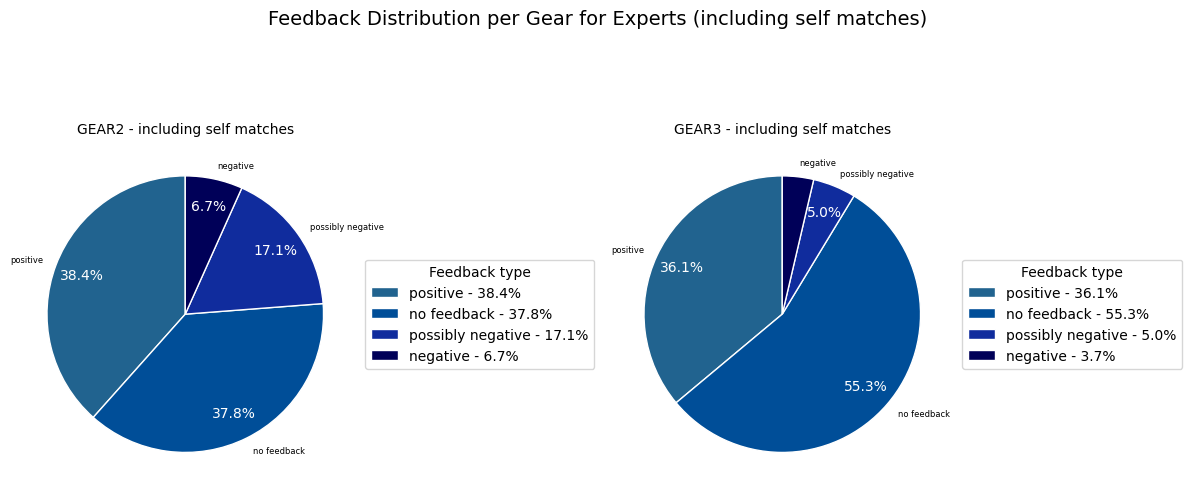

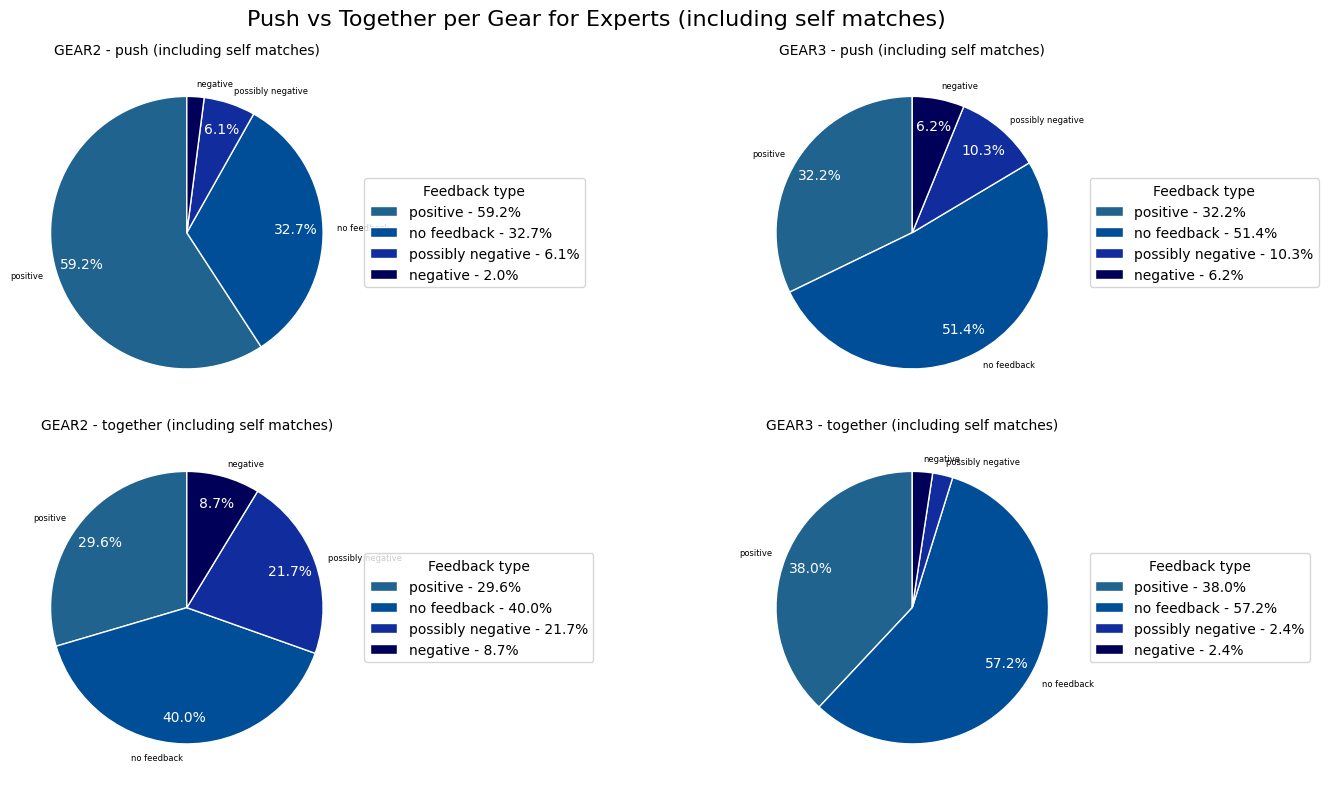

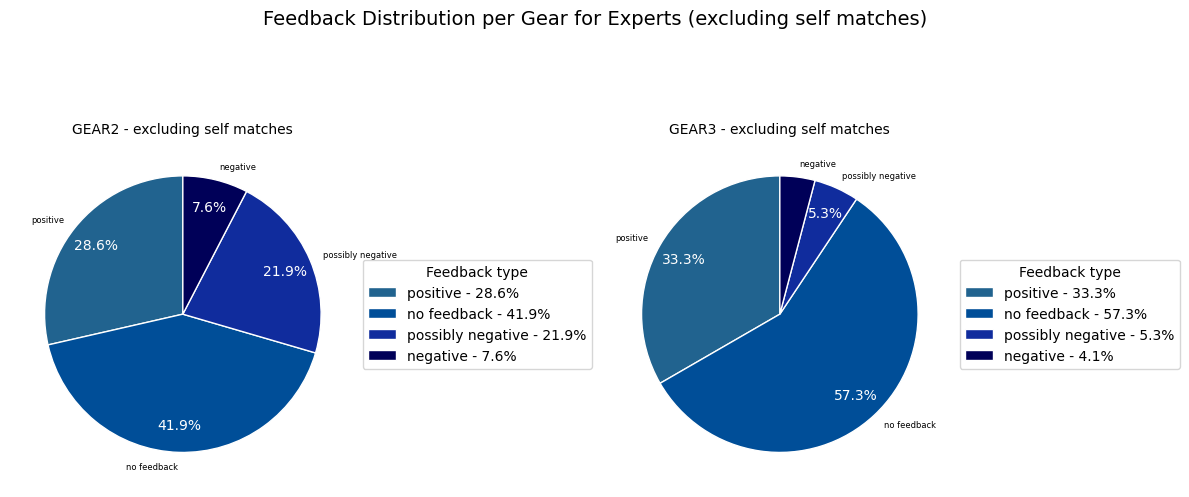

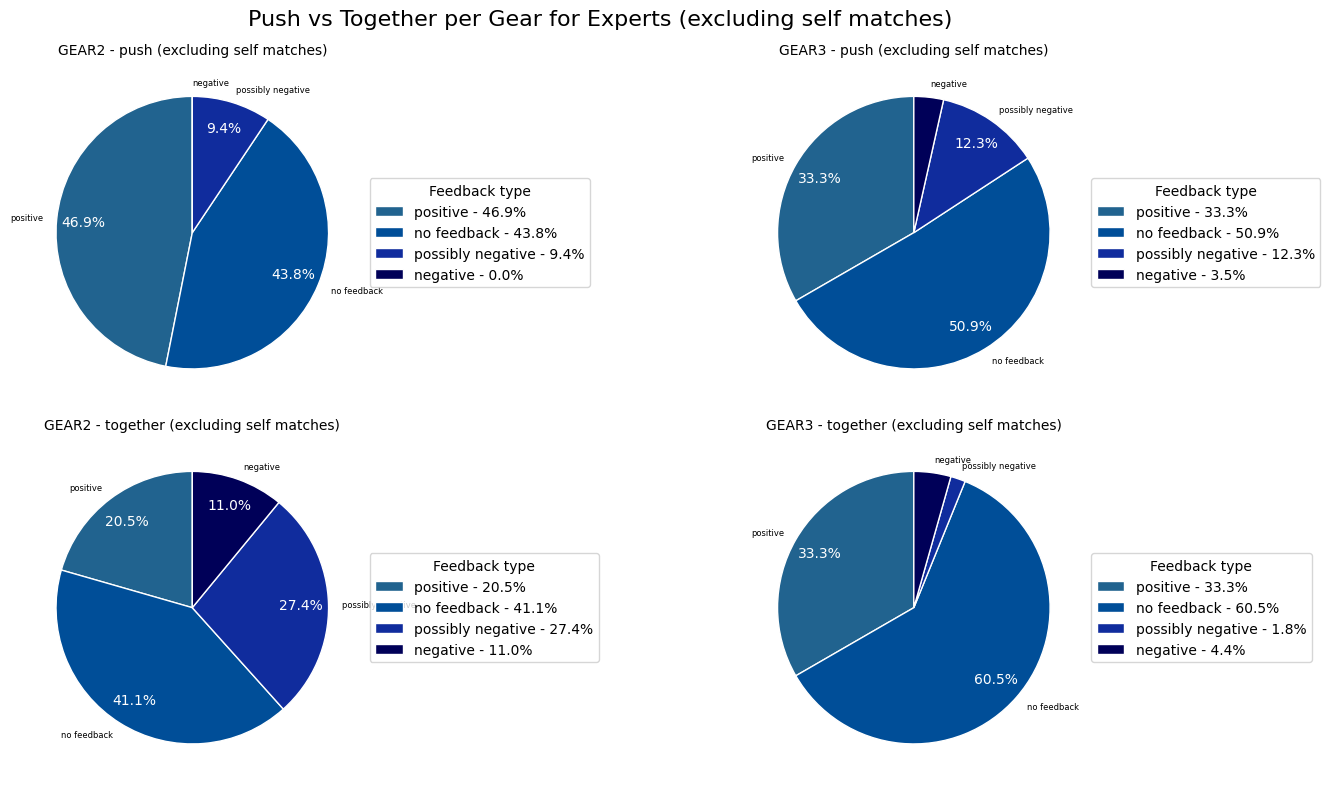

In [270]:
# load data
with open("../../data/feedback_evaluation/evaluation_wide_legs_experts.json") as f:
    data_experts = json.load(f)

# Generate plots for each match type
for match_type in ["with_self_matches", "no_self_matches"]:
    plot_feedback_pies_grid(data_experts, match_type, "Experts")
    plot_push_vs_together_grid(data_experts, match_type, "Experts")

In [271]:
# Scoring weights for each sentiment
sentiment_weights = {
    "positive": 1,
    "no feedback": 0.5,
    "possibly negative": -0.5,
    "negative": -1
}

# Initialize gear scores
gear_scores = {
    "gear2": {},
    "gear3": {}
}

# Iterate over each video and accumulate scores for each gear
for video_id, video_data in data_experts.items():
    for gear in ['gear2', 'gear3']:
        score = 0
        for match_type in ['with_self_matches', 'no_self_matches']:
            if match_type in video_data and gear in video_data[match_type]:
                feedback_category = video_data[match_type][gear].get('all', {})
                for feedback, weight in sentiment_weights.items():
                    count = feedback_category.get(feedback, 0)
                    score += count * weight
        gear_scores[gear][video_id] = score

# Find best and worst videos per gear
for gear in ['gear2', 'gear3']:
    scores = gear_scores[gear]
    best_video = max(scores, key=scores.get)
    worst_video = min(scores, key=scores.get)
    print(f"\n🎯 {gear.upper()}")
    print(f"✅ Best Video: {best_video} (Score: {scores[best_video]})")
    print(f"❌ Worst Video: {worst_video} (Score: {scores[worst_video]})")


🎯 GEAR2
✅ Best Video: 145 (Score: 20.0)
❌ Worst Video: 11 (Score: -2.5)

🎯 GEAR3
✅ Best Video: 158 (Score: 26.0)
❌ Worst Video: 150 (Score: 12.0)


## For mixed level

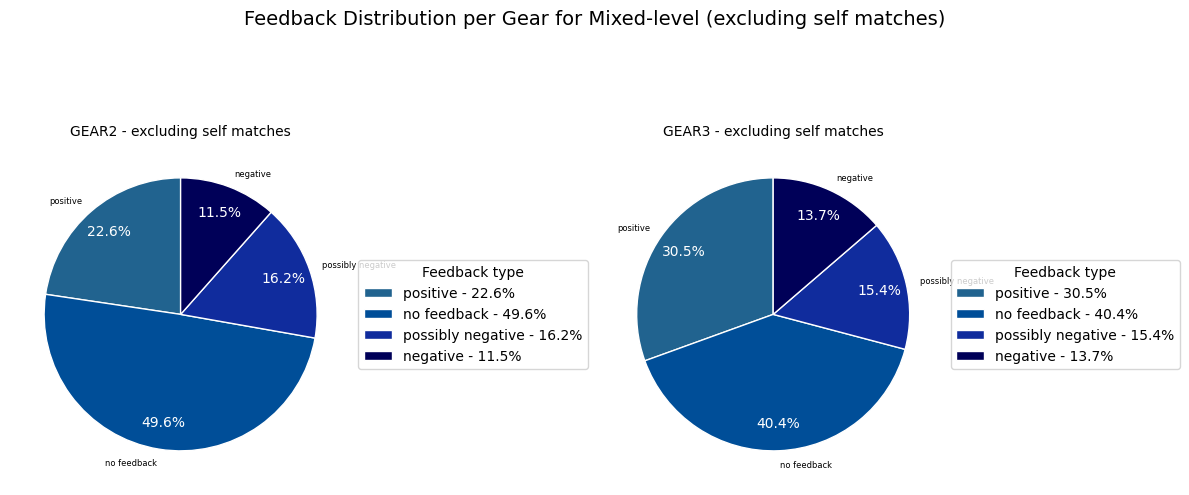

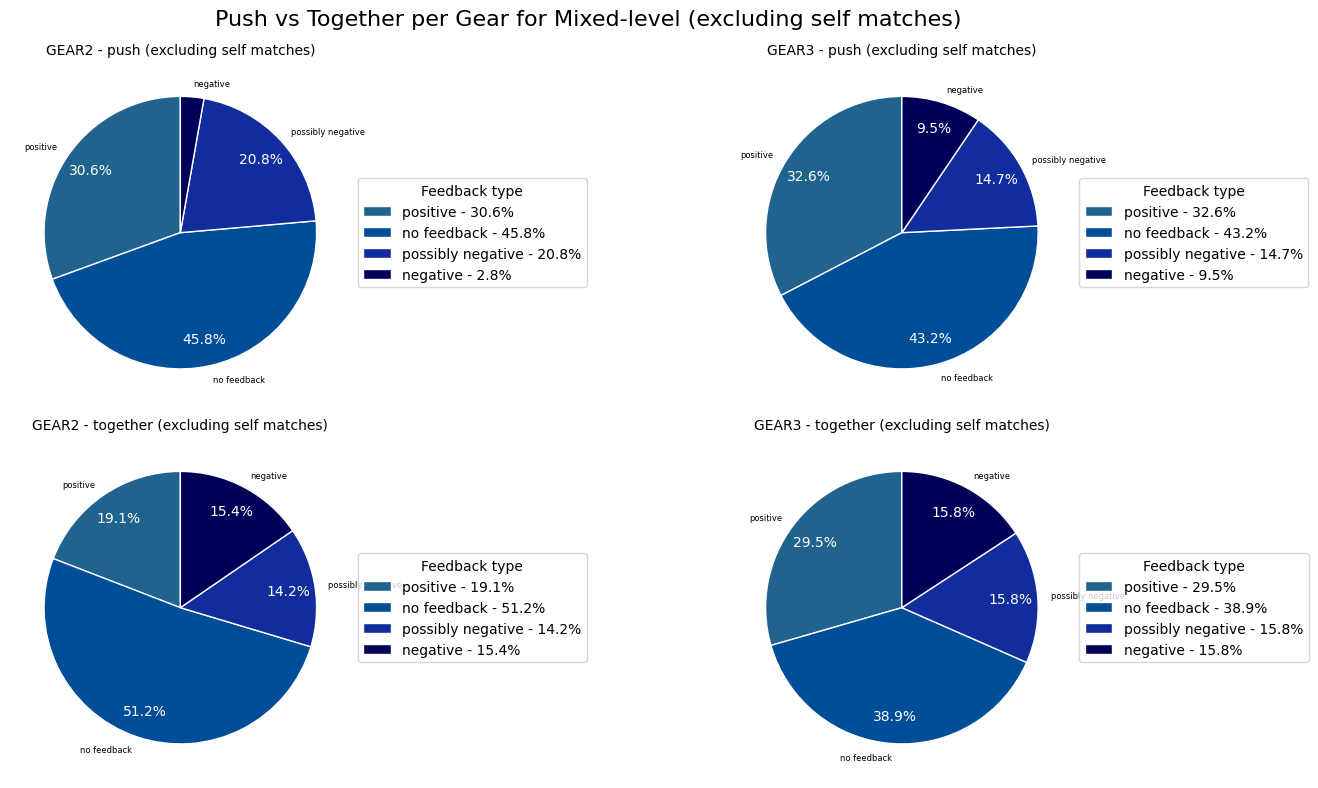

In [272]:
# load data
with open("../../data/feedback_evaluation/evaluation_wide_legs_mixed_level.json") as f:
    data_mixed_level = json.load(f)

# Generate plots for each match type
for match_type in ["no_self_matches"]:
    plot_feedback_pies_grid(data_mixed_level, match_type, "Mixed-level")
    plot_push_vs_together_grid(data_mixed_level, match_type, "Mixed-level")

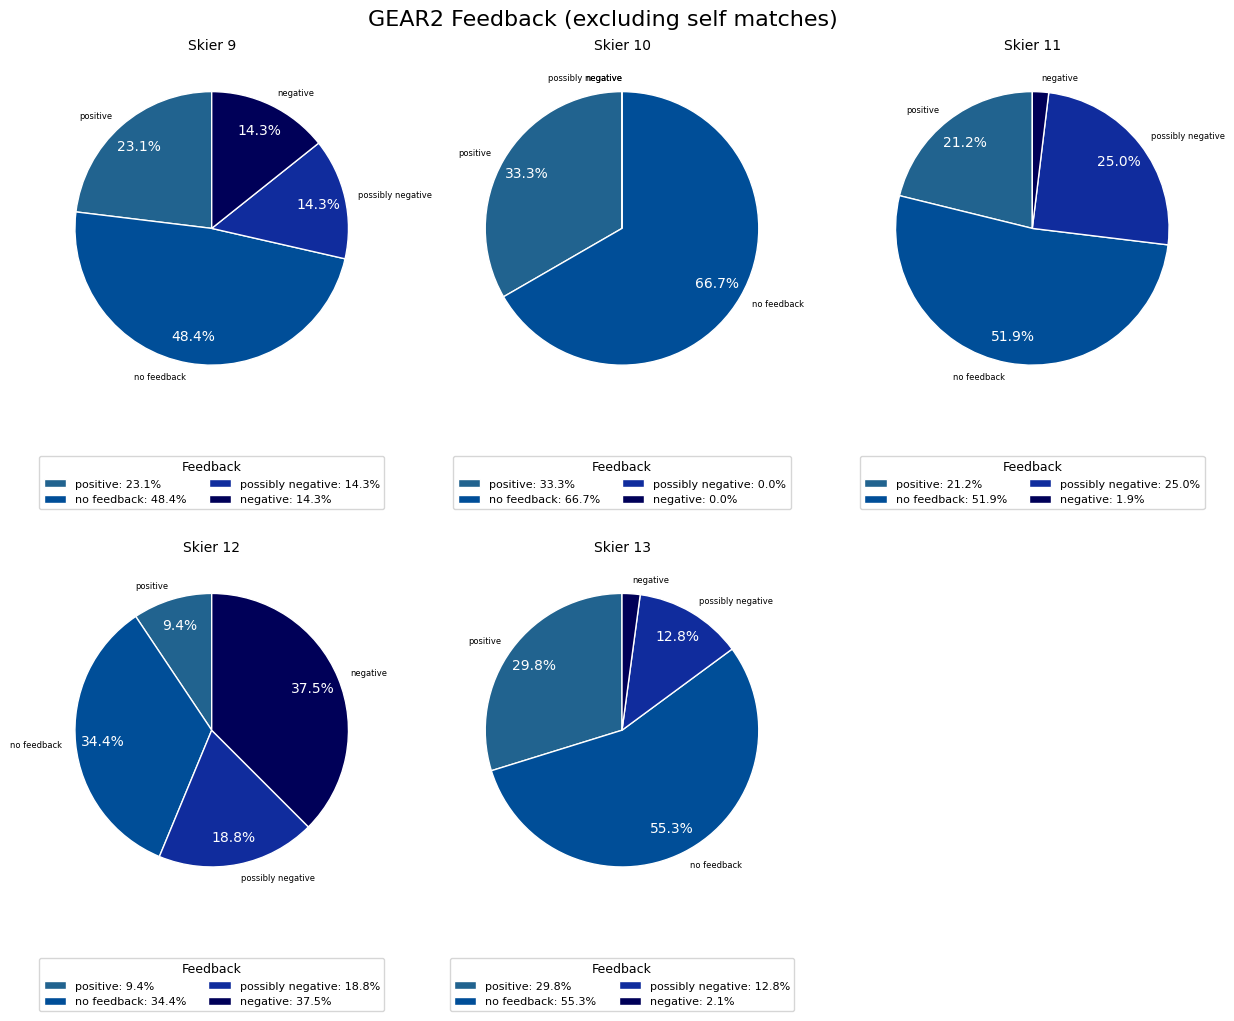

In [273]:
#plot_feedback_per_skier(data_mixed_level)
plot_skier_feedback_pies(data_mixed_level, gear="gear2")

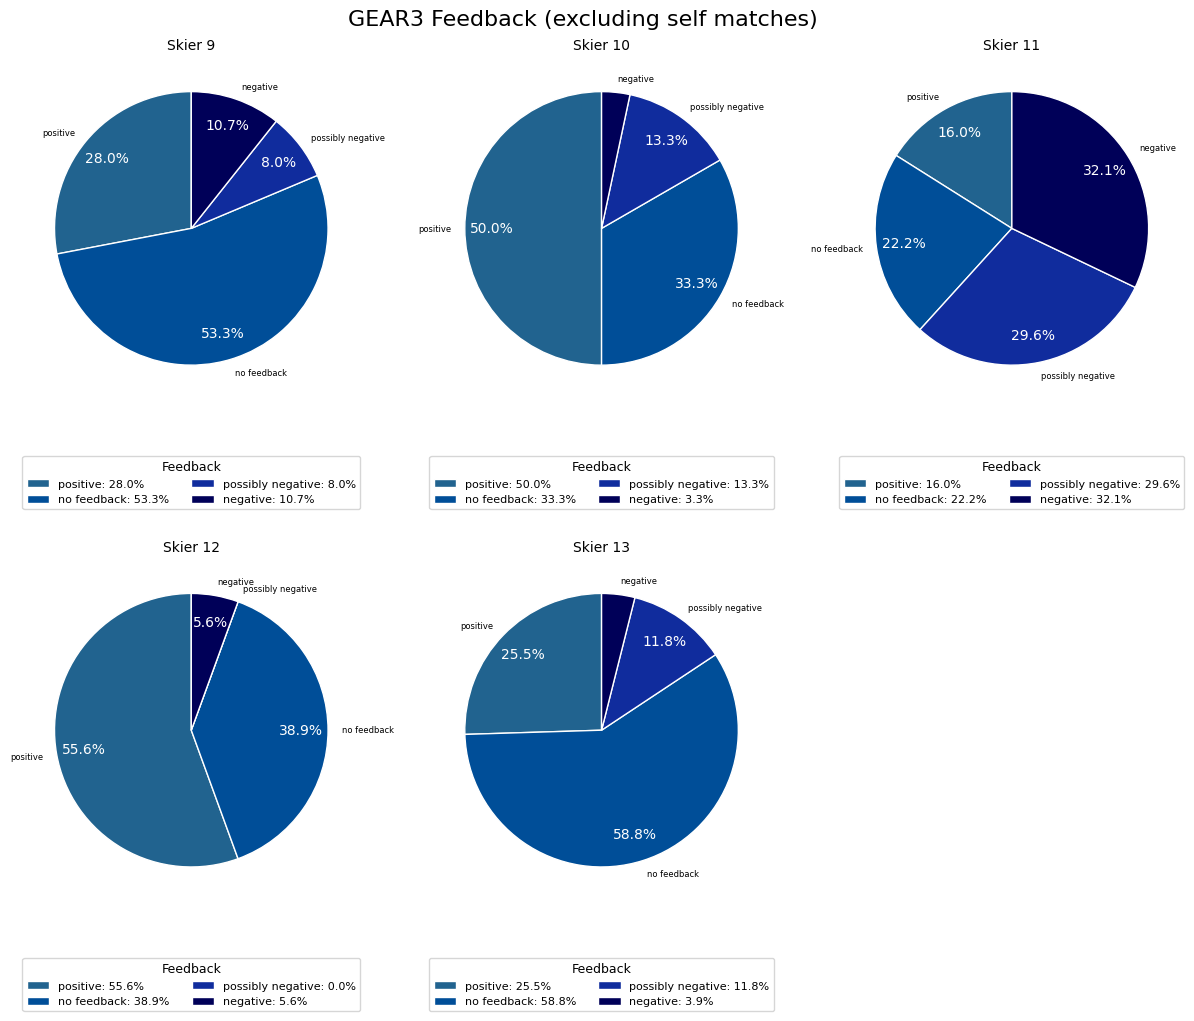

In [274]:
plot_skier_feedback_pies(data_mixed_level, gear="gear3")

In [275]:
# Scoring weights for each sentiment
sentiment_weights = {
    "positive": 1,
    "no feedback": 0.5,
    "possibly negative": -0.5,
    "negative": -1
}

# Initialize gear scores
gear_scores = {
    "gear2": {},
    "gear3": {}
}

# Iterate over each video and accumulate scores for each gear
for video_id, video_data in data_mixed_level.items():
    for gear in ['gear2', 'gear3']:
        score = 0
        for match_type in ['with_self_matches', 'no_self_matches']:
            if match_type in video_data and gear in video_data[match_type]:
                feedback_category = video_data[match_type][gear].get('all', {})
                for feedback, weight in sentiment_weights.items():
                    count = feedback_category.get(feedback, 0)
                    score += count * weight
        gear_scores[gear][video_id] = score

# Find best and worst videos per gear
for gear in ['gear2', 'gear3']:
    scores = gear_scores[gear]
    best_video = max(scores, key=scores.get)
    worst_video = min(scores, key=scores.get)
    print(f"\n🎯 {gear.upper()}")
    print(f"✅ Best Video: {best_video} (Score: {scores[best_video]})")
    print(f"❌ Worst Video: {worst_video} (Score: {scores[worst_video]})")


🎯 GEAR2
✅ Best Video: 115 (Score: 22.0)
❌ Worst Video: 80 (Score: -7.0)

🎯 GEAR3
✅ Best Video: 60 (Score: 30.0)
❌ Worst Video: 92 (Score: -14.0)
